In [2]:
%matplotlib inline

import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, pickle, copy
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    

from scipy import optimize

import cv2 

matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=14)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)


matplotlib.rc('figure', figsize=(12, 9))


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0')

Chapter 4. 푸리에 변환을 이용한 이미지 처리 (Image Processing Using Fourier Transform)
===

# 4.1. 푸리에 급수와 푸리에 변환의 수학적 성질


## 푸리에 급수
주기 $T$ 를 갖는 연속함수 $f(t)$ 는 다음과 같은 푸리에 급수로 표현 할 수 있다.

$$
\begin{aligned}
f(t) &= \sum_{n=-\infty}^{\infty} F_n \exp \left(\dfrac{i 2\pi n}{T}t\right)\,,\\
F_n &= \dfrac{1}{T}\int_{-T/2}^{T/2} f(t) \exp \left(-\dfrac{i2\pi n }{T}t \right)\, dt\,, \qquad n\in \mathbb{Z}
\end{aligned}
$$

<br>

### 기저함수의 직교성

$$
\int_{-T/2}^{T/2} \exp \left( \dfrac{i 2\pi m}{T}t\right) \exp \left(-\dfrac{i 2\pi n}{T}t \right)\, dt = \delta_{nm}
$$

<br>

### 주기함수와 푸리에 급수

- 모든 주기성을 갖는 연속함수는 푸리에 급수로 표현 할 수 있다.



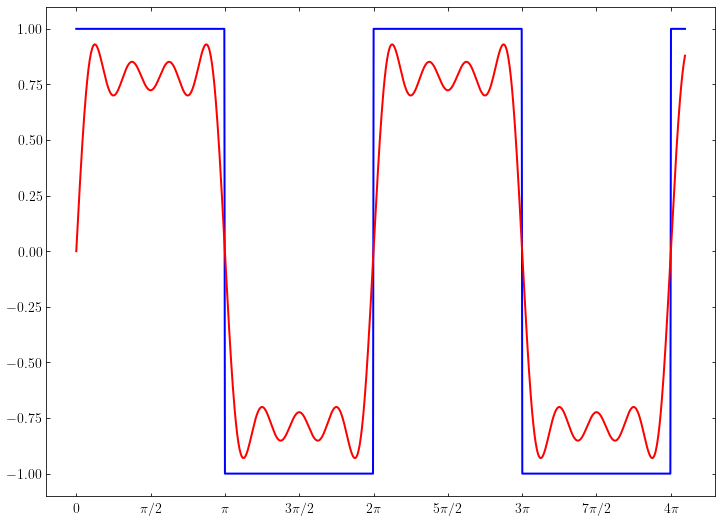

In [24]:
ax = plt.gca()
x=np.linspace(0, 4.0*np.pi+0.3, 1000)
f1=np.ones(x.shape)
f1[np.fmod(x, 2*np.pi)>np.pi]=-1
plt.plot(x, f1, "b-", lw=2)
f2=np.sin(x)+1./3 *np.sin(3*x)+1./5 *np.sin(5*x)+1./7*np.sin(7*x)
plt.plot(x, f2, "r-", lw=2)
ax.set_xticks(np.arange(0, 4*np.pi+0.01, np.pi/2))
labels = ['$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$',
          r'$5\pi/2$', r'$3\pi$', r'$7\pi/2$', r'$4\pi$']
ax.set_xticklabels(labels)
plt.show()

## 푸리에 변환

### 1차원 푸리에 변환
$$
\begin{aligned}
F(\mu) &= \mathfrak{I} \left[f(t)\right]=\int_{-\infty}^{\infty} f(t)e^{-2i\pi \mu t}\, dt\,, \\
f (t) &= \mathfrak{I}^{-1} \left[F(\mu)\right] = \int_{-\infty}^{\infty} F(\mu) e^{2i \pi \mu t} \, d\mu
\end{aligned}
$$



### 2차원 푸리에 변환
$$
\begin{aligned}
F(u,\,v) &= \mathfrak{I} \left[f(x,\,y)\right]=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} f(x,\,y)e^{-2i\pi (ux+vy)}\, dxdy\,, \\
f (x,\,y) &= \mathfrak{I}^{-1} \left[F(u,\,v)\right] = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} F(\mu) e^{2i \pi (ux+vy)} \, dudv
\end{aligned}
$$

<br>
### 주의 

앞으로 나올 푸리에 변환 이미지는 

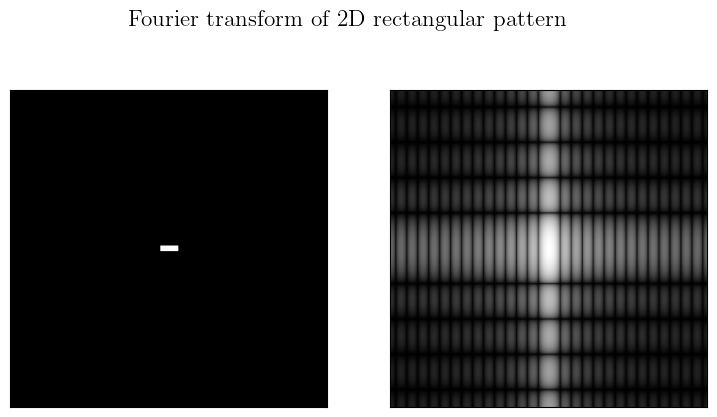

In [49]:
U, V = 30, 9
x0, y0 = np.arange(512), np.arange(512)
x, y = np.meshgrid(x0, y0)
img1 = ((np.abs(x-256)<U/2)&(np.abs(y-256)<V/2)).astype(np.float64)


img2 = np.fft.fftshift(np.fft.fft2(img1))

fig1 = plt.figure(figsize=(9,5), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2= fig1.add_subplot(121), fig1.add_subplot(122)
ax1.imshow(img1, cmap='gray')
ax2.imshow(np.log(1.+np.abs(img2)), cmap='gray')

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig1.suptitle("Fourier transform of 2D rectangular pattern")
plt.show()

## 푸리에 변환의 몇가지 수학적 성질

### 1. Similarity

$$
f (x,\,y) \iff F(u,\,v) \implies f(ax,\,by) =\dfrac{1}{ab} F\left(\dfrac{u}{a},\, \dfrac{v}{b}\right)
$$


---

$$
\begin{aligned}
\mathfrak{I}[f(ax,\,by)] &= \iint f(ax,\, by) e^{-2i\pi (ux+vy)}\,dxdy \qquad & t=ax,\, s=by\\
&= \dfrac{1}{ab} \iint f(s,\,t) e^{-2i \pi (ut/a+vs/b)}\, dtds \\
&= \dfrac{1}{ab} F \left(\dfrac{u}{a},\, \dfrac{v}{b} \right)
\end{aligned}
$$

<br>

### 2. Shift Theorem

$$
f(x,\,y) \iff F(u,\,v) \implies f(x-a,\, y-b) \iff \exp (i2\pi (au+bv)) F(u,\,v)
$$

---

$$
\begin{aligned}
\mathfrak{I}[f(x-a,\, y-b) ]&= \iint f(x-a,\, y-b) e^{-2i\pi (ux+vy)} \,dxdy \qquad & t=x-a,\, s=y-b\\
&=\iint f(t,\,s) e^{-2i\pi (ux+vy)} e^{2i\pi (au+bv)} \, dxdy \\
&= e^{2i\pi (au+bv)}F(u,\,v)
\end{aligned}
$$

<br> 

### 3. 도함수의 푸리에 변환

$$
\mathfrak{I}[f(x)] = F(u)   \implies \mathfrak{I}\left[ \dfrac{d^kf}{dx^k} \right] =( 2i\pi u)^k F(u) 
$$

---
$k=1$ 인 경우만 보이면 나머지는 쉽게 일반화 된다. $\mathfrak{I}[f(x)]=F(u)$ 이면 $f(x)=\displaystyle \int_{-\infty}^{\infty} F(u)e^{2i\pi ux}\, du$ 이므로

$$
f'(x) =  \int_{-\infty}^{\infty}(2i\pi u) F(u)e^{2i \pi ux} \, du
$$

이다. 따라서 

$$
\mathfrak{I}[f'(x)] = (2i\pi u) F(u)
$$
이다.


### Fourier Spectrum, Phase, Fourier Power Spectrum

$F(u,\,v)$ 를 극좌표 형태로 다음과 같이 표현 할 수 있다. 

$$
F(u,\,v) = |F(u,\,v)| e^{i\Phi(u,\,v)}
$$


이 때 $|F(u,\,v)|$ 를 **푸리에 스펙트럼 (Fourier spectrum)** 이라 하고, $\Phi(u,\,v)$ 를 **위상 (phase)** 이라 한다. 또한 $P(u,\,v) =|F(u,\,v)|^2$ 를 **푸리에 파워 스펙트럼 (Fourier power spectrum)** 이라 한다.

## 평행이동과 회전변환의 푸리에 변환

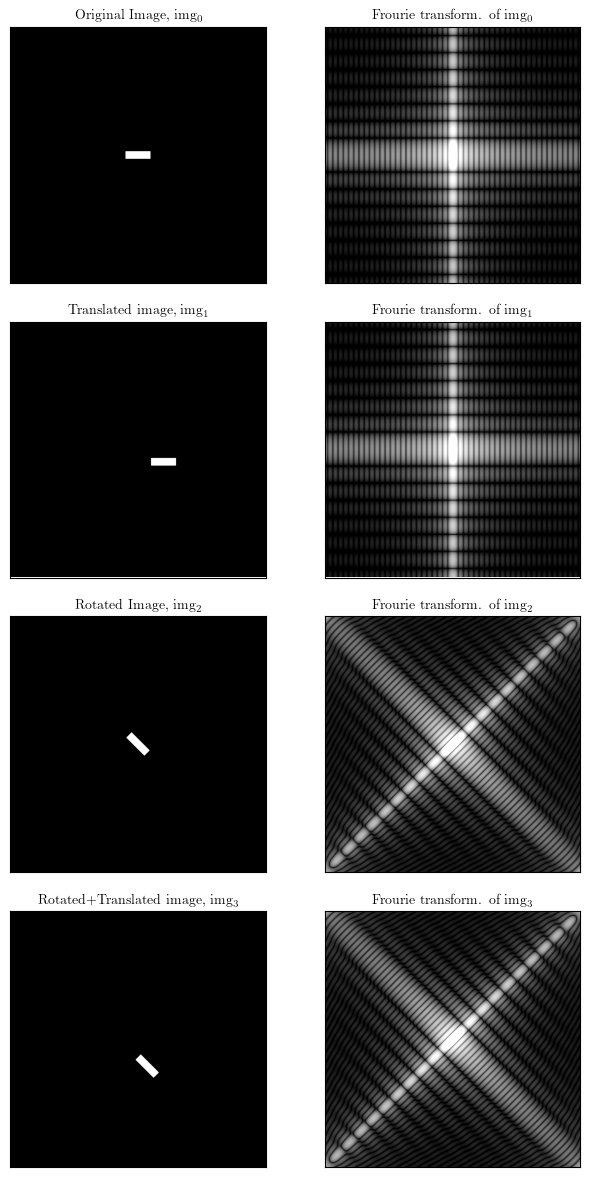

In [127]:
# 아래에서 소개할 numpy 의 fft module 을 사용하였음.
import numpy.fft
fig1 = plt.figure(figsize=(7,12), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = fig1.add_subplot(421), fig1.add_subplot(422),\
    fig1.add_subplot(423), fig1.add_subplot(424), fig1.add_subplot(425), fig1.add_subplot(426), \
    fig1.add_subplot(427), fig1.add_subplot(428),

U, V = 1., 0.3
x0, y0 = np.linspace(-5, 5, 501), np.linspace(-5, 5, 501)
x, y = np.meshgrid(x0, y0)
img1 = ((np.abs(x)<U/2)&(np.abs(y)<V/2)).astype(np.float64)
ax1.imshow(img1, cmap='gray')
ax1.set_title("Original Image, img$_0$", size=10)
u0, v0 = np.linspace(-13, 13, 302), np.linspace(-13, 13, 302)
u, v = np.meshgrid(u0, v0)
#img2 = U*V*np.sin(np.pi*U*u)/(np.pi*U*u)*np.sin(np.pi*V*v)/(np.pi*V*v)
img2 = np.fft.fftshift(np.fft.fft2(img1))
ax2.imshow(np.log(1.0+np.abs(img2)), cmap='gray', vmin=0.2, vmax=5)
ax2.set_title("Frourie transform. of img$_0$", size=10)

# Transilation of image
img3 = ((np.abs(x-1)<U/2)&(np.abs(y-0.5)<V/2)).astype(np.float64)
ax3.imshow(img3, cmap='gray')
ax3.set_title("Translated image, img$_1$", size=10)
img4 = np.fft.fftshift(np.fft.fft2(img3))
ax4.imshow(np.log(1.0+np.abs(img4)), cmap='gray', vmin=0.2, vmax=5.)
ax4.set_title("Frourie transform. of img$_1$", size=10)


# Rotation of image
x1 = x*np.cos(np.pi/4)+y*np.sin(np.pi/4)
y1 = -x*np.sin(np.pi/4)+y*np.cos(np.pi/4)
img5 = ((np.abs(x1)<U/2)&(np.abs(y1)<V/2)).astype(np.float64)
ax5.imshow(img5, cmap='gray')
ax5.set_title("Rotated Image, img$_2$", size=10)
img6 = np.fft.fftshift(np.fft.fft2(img5))
ax6.imshow(np.log(1.0+np.abs(img6)), cmap='gray', vmin=0.2, vmax=5.)
ax6.set_title("Frourie transform. of img$_2$", size=10)

# Rotated and translated image
img7 = ((np.abs(x1-1)<U/2)&(np.abs(y1-0.5)<V/2)).astype(np.float64)
ax7.imshow(img7, cmap='gray')
ax7.set_title("Rotated+Translated image, img$_3$", size=10)
img8 = np.fft.fftshift(np.fft.fft2(img7))
ax8.imshow(np.log(1.0+np.abs(img8)), cmap='gray', vmin=0.2, vmax=5.)
ax8.set_title("Frourie transform. of img$_3$", size=10)






for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig1.tight_layout()
plt.show()

## 주기적 임펄스 함수의 푸리에 변환

단위 임펄스 함수(디렉 델타 함수)가 $T$ 를 주기로 반복되는 함수를 주기적 임펄스 함수라 하며 이를 $S_T(t)$ 라 하자. 이는 주기함수이므로 푸리에 급수로 표현 할 수 있으며 다음과 같다. 

$$
\begin{aligned}
S_T(t) &= \sum_{n=-\infty}^{\infty} \delta \left(t-nT \right) \,, \\
&=\dfrac{1}{T} \sum_{n=-\infty}^{\infty} \exp \left( \dfrac{-i2n\pi t}{T}\right)
\end{aligned}
$$

단일 임펄스 함수 $\delta(\mu-\mu_0)$ 에 대한 푸리에 변환은 다음과 같다.

$$
\mathfrak{I}[\delta (\mu-\mu_0)] = \int_{-\infty}^{\infty} \delta (\mu-\mu_0) e^{2i\pi \mu t}\, d\mu = e^{2i\pi \mu_0 t}
$$

따라서,

$$
\mathfrak{I}^{-1} \left[ \delta \left( \mu-\dfrac{n}{T} \right) \right] = \exp \left( \dfrac{2in\pi t}{t} \right) \iff \mathfrak{I}\left[  \exp \left( \dfrac{2in\pi t}{t} \right) \right] =  \delta \left( \mu-\dfrac{n}{T} \right)
$$

이다. 이를 이용하면 $s_T(t)$ 의 푸리에 변환식 $S(\mu)=\mathfrak{I}[s_N(t)]$ 를 계산 할 수 있으며 다음과 같다.

$$
S (\mu) = \mathfrak{I}\left[\dfrac{1}{T} \sum_{n=-\infty}^{\infty} \exp \left( \dfrac{-i2n\pi t}{T}\right)\right] = \dfrac{1}{T} \sum_{n=-\infty}^{\infty} \mathfrak{I}\left[ \exp \left( \dfrac{-i2n\pi t}{T}\right) \right] = \dfrac{1}{T} \sum_{n=-\infty}^{\infty} \delta \left(\mu - \dfrac{n}{T}\right)
$$




## Convolution 의 푸리에 변환

두 함수 $f(t),\, g(t)$ 의 convolution  $f(t) \ast g(t)$ 은 다음과 같이 정의된다.

$$
f(t) \ast g(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t-\tau) \, d\tau
$$

$F(\mu)= \mathfrak{I}[f(t)],\, G(\mu)=\mathfrak{I}[g(t)]$ 라 할 때, $f(t)\ast g(t)$ 의 푸리에 변환을 구하면,

$$
\begin{aligned}
\mathfrak{I}[f(t) \ast g(t)] &= \int_{-\infty}^{\infty} \left[ \int_{-\infty}^{\infty} f(\tau)g(t-\tau) d\tau\right] e^{-2in\pi \mu t}\, dt \\
&= \int_{-\infty}^{\infty}f(\tau) \left[  \int_{-\infty}^{\infty} g(t-\tau)e^{-2in \pi \mu t}\, dt\right] \,d\tau \\
&= \int_{-\infty}^{\infty} f(\tau) G(\mu)e^{-2in \pi \mu \tau} \, d\tau \\
&= F(\mu)G(\mu)
\end{aligned}
$$


즉 합성곱의 푸리에 변환은 푸리에 변환의 곱이다. 이를 응용하면 두 함수의 곱의 푸리에변환은 합성곱이 됨을 보일 수 있다. 즉,

$$
\mathfrak{I}[f(t)g(t)]=F(\mu)\ast G(\mu)
$$

가 된다.

# 4.2. 푸리에 변환과 샘플링 (sampling)

#### 샘플링
임의의 연속함수 $f(t)$ 를 $T$ 를 주기로 샘플링 하였다고 하자. 그렇다면 이 샘플링 $\tilde{f}(t)$ 은 다음과 같은 식으로 표현 할 수 있다.

$$
\tilde{f}(t) = f(t)S_T(t)\sum_{n=-\infty}^{\infty} f(t) \delta (t-nT)
$$

즉 연속 신호에 대해 주기적으로 신호를 뽑아 불연속 신호로 만드는 것을 **sampling** 이라 한다. 

<br>

#### 샘플링 된 신호의 푸리에 변환

이 때 $\mathfrak{I}[f(t)]= F(\mu),\, \mathfrak{I}[s_T(t)]= S(\mu)$ 라 하자 $\displaystyle S(\mu)=\dfrac{1}{T} \sum_{n=-\infty}^{\infty} \delta \left( \mu - \dfrac{n}{T}\right)$ 임은 알고 있다. 그렇다면 $\tilde{F}(\mu)=\mathfrak{I}\left[\tilde{f}(t) \right]$ 를 구하면,

$$
\begin{aligned}
\tilde{F}(\mu) & = F(\mu)\ast S(\mu) = \int_{-\infty}^{\infty} F(\tau)S(\mu-\tau)\, d\tau \\
&= \dfrac{1}{T} \sum_{n=-\infty}^{\infty}\int_{-\infty} F(\tau) \delta \left(\mu-\tau-\dfrac{n}{T}\right)\, d\tau \\
&= \dfrac{1}{T}\sum_{n=-\infty}^{\infty} F\left( \mu - \dfrac{n}{T} \right)
\end{aligned}
$$

이다. 즉, 주기 $T$ 로 샘플링된 연속 함수 $f(t)$의 함수의 푸리에 변환은 원래 함수의 푸리에 변환 $F(\mu)$ 를 주기 $1/T$ 를 갖는 임펄스 함수로 바꾼 형태임을 알 수 있다.


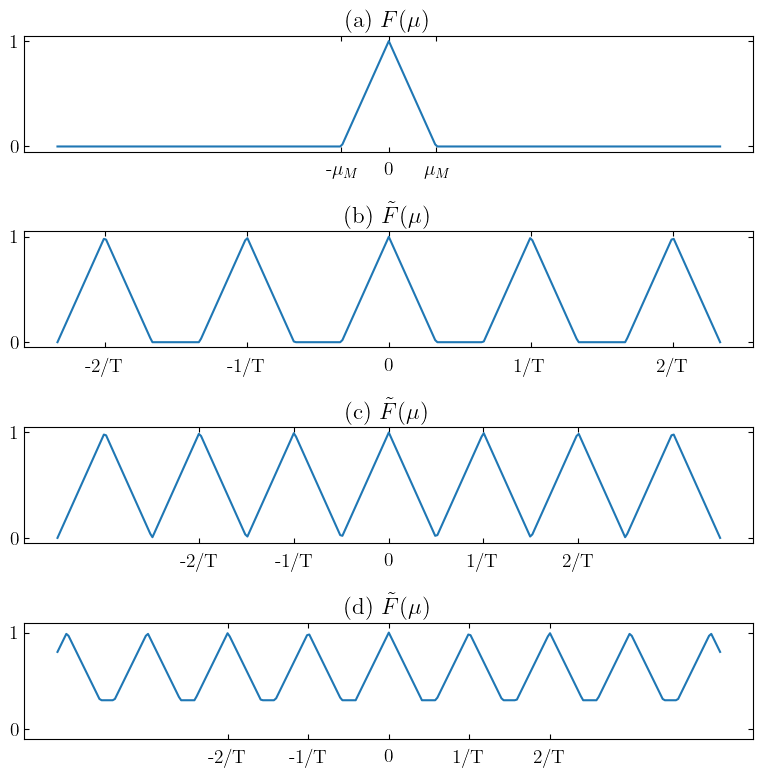

In [113]:
fig1 = plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4 = fig1.add_subplot(411), fig1.add_subplot(412),\
                    fig1.add_subplot(413), fig1.add_subplot(414),

def skew(x, x0, hw):
    y = np.zeros(x.shape)
    y[(x>x0-hw) & (x<=x0)]= 1./hw*(x[(x>x0-hw) & (x<=x0)]-x0)+1
    y[(x>x0) & (x<x0+hw)]= -1./hw*(x[(x>x0) & (x<x0+hw)]-x0)+1
    
    return y

x=np.linspace(-7, 7, 301)
y1=skew(x, 0, 1)
ax1.plot(x, y1)
ax1.set_title("(a) $F(\mu)$")
ax1.set_xticks([-1,0, 1])
ax1.set_xticklabels(["-$\mu_M$", 0,"$\mu_M$"])

y2 = np.zeros(x.shape)
for i in np.arange(-9, 10, 3):
    y2+=skew(x, i, 1)
ax2.plot(x, y2)
ax2.set_title("(b) $\\tilde{F} (\mu)$")
ax2.set_xticks([-6, -3, 0, 3, 6])
ax2.set_xticklabels(["-2/T", "-1/T", 0,"1/T", "2/T"])


y3 = np.zeros(x.shape)
for i in np.arange(-10, 12, 2):
    y3+=skew(x, i, 1)
ax3.plot(x, y3)
ax3.set_title("(c) $\\tilde{F} (\mu)$")
ax3.set_xticks([-4, -2, 0, 2, 4])
ax3.set_xticklabels(["-2/T", "-1/T", 0,"1/T", "2/T"])

y4 = np.zeros(x.shape)
for i in np.arange(-1.7*10, 11, 1.7):
    y4+=skew(x, i, 1)
ax4.plot(x, y4)
ax4.set_ylim(-0.1, 1.1)
ax4.set_title("(d) $\\tilde{F} (\mu)$")
ax4.set_xticks([-3.4, -1.7, 0, 1.7, 3.4])
ax4.set_xticklabels(["-2/T", "-1/T", 0,"1/T", "2/T"])

fig1.tight_layout()

#### 밴드-한계 신호 (band-limited signal), Over-sampling, under-sampling, critical-sampling, aliasing

- 위의 그림을 보자. 원본연속함수(연속신호) $f(t)$ 를 푸리에 변환한 함수 중, 그래프 (a) 와 같이 일부 구간 $[-\mu_M,\,\mu_M]$에 대한 변환 신호 $F(\mu)$ 만을 알고 있는 상황이라고 가정하자. 이렇계 특정 구간을 제외하고 $F(\mu)=0$ 일 때 이를 밴드한계신호라 한다.

- $f (t)$ 를 주기 $T$ 를 조절해 가며 샘플링한 함수를 푸리에 변환한다고 하자. 만약, 주기를 $1/T>2\mu_M$ 이 되도록 샘플링하면 $F(\mu)$ 가 주기적으로 배열되며 그간격은 $1/T$ 가 이되겠지만, $1/T>2\mu_M$ 이므로, 결과는 그림 (b) 와 같이 띄엄띄엄 배열된 삼각형 신호가 될 것이다. 즉 $\tilde{F}(\mu)$ 가 불연속 함수가 된다. 그러나 원래 $F(\mu)$ 가 가지고 있던 함수정보가 고스란히 남아 있으므로, 결과물로 부터 다시 역변환을 취하면 원래 함수 (신호값) 을 복원 할 수 있다. 이러한 결과를 **오버-샘플링 (over-sampling)** 이라 한다.

- 만약, 주기 조건이 $1/T < 2\mu_M$ 이라면 이번에도 $F(\mu)$ 가 주기적으로 배열되겠지만, $1/T < 2\mu_M$ 이므로, 결과는 그래프 (d) 처럼 삼각형 신호 중 일부가 파묻힌 결과가 될 것이다. 비록 $F(\mu)$ 는 연속 함수가 되었지만, 원래의 정보를 잃어 버리게 되며, 이러한 결과를 **언더-샘플링 (under-sampling)** 이라 한다.

- 만약 주기가 $1/T= 2\mu_M$ 로서 딱 맞다면, 그림 (c) 처럼, $F(\mu)$ 는 삼각형 신호가 제대로 연속 배열된 결과가 된다. 이러한 결과를 **critical-sampling** 이라 한다.

- 따라서 원래 함수의 신호를 복원하기 위한 샘플링 충분 조건은 $1/T\ge 2\mu_M$ 이 될 것이다. 이것은 소위 나이퀴스트-샤논 샘플링 정리의 결과이다.

- 이 정리에 따르면, 어떤 신호든 밴드-한계 함수가 그 함수의 샘플들로부터 복원되기 위해서는, 샘플링 주기의 역수$1/T$ 가 샘플링된 밴드의 최대값의 두 배보다 커야 한다. 만약, 주기의 역수가 이 조건을 만족시키지 못한다면 (즉, 언더-샘플링된 상황), 복원된 신호는 완벽하지 않을 것이며, 이러한 상황을 **주파수 앨리어싱 (frequency aliasing)** 혹은 그냥 **앨리어싱** 이라고 한다.

- 앨리어싱은 주로 원래 이미지의 해상도보다 낮은 해상도로 이미지를 샘플링하거나, 이미지 획득 장치의 샘플링 간격이 피사체 자체의 고유 구조 특징보다 더 클 때 발생합니다.

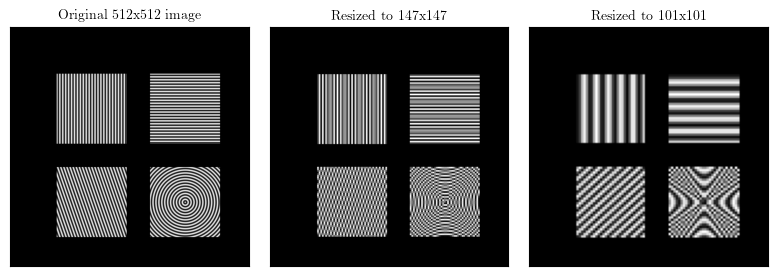

In [142]:
fig1 = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3= fig1.add_subplot(131), fig1.add_subplot(132), fig1.add_subplot(133)


X, Y = np.meshgrid(np.arange(512), np.arange(512))

Z = np.zeros(X.shape)

X0, Y0 = np.meshgrid(np.arange(150), np.arange(150))
th = 19*np.pi/180
X1, Y1 =np.cos(th)*X0 - np.sin(th)*Y0, np.sin(th)*X0 + np.cos(th)*Y0

Z1 = 100*np.cos(X0)+100
Z2 = 100*np.cos(Y0)+100
Z3 = 100*np.sin(X1)+100
Z4 = 100*np.cos(np.sqrt((X0-75)**2+(Y0-75)**2))+100



Z[100:250, 100:250]=Z1
Z[100:250, 300:450]=Z2
Z[300:450, 100:250]=Z3
Z[300:450, 300:450] = Z4

ax1.imshow(Z, cmap='gray')
ax1.set_title("Original 512x512 image", size=10)

img2=cv2.resize(Z,(147, 147))
ax2.imshow(img2, cmap='gray')
ax2.set_title("Resized to 147x147", size=10)

img3 = cv2.resize(Z, (101, 101))
ax3.imshow(img3, cmap='gray')
ax3.set_title("Resized to 101x101", size=10)


for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig1.tight_layout()
plt.show()

# 4.3 이산 푸리에 변환 (Discrete Fourier Transformation, DFT)

1차원 공간상의 함수 $f$ 에 대해 $k$ 번째 에서의 값을 $f_k$ 라 하자. 그리고 이 수열을 $\mathbf{f}$ 라 하자. 즉,
$$
\mathbf{f}=(f_0,\ldots,\,f_{N-1})
$$

이다.

우리는 여기서 한가지 가정을 하게 되는데 $f$ 이 주기 $N$ 을 갖는다는 것이다. 즉 $f_{k+N}=f_k$ 이다. 이 때 $\mathfrak{I}[\mathbf{f}]=\mathbf{F}=[F_1,\ldots,\,F_{N-1}]$ 의 $F_\mu$ 는 다음과 같이 구할 수 있다.

$$
F_\mu = \dfrac{1}{N}\int_{0}^{N-1} f(t) \exp \left(-\dfrac{i2\pi \mu }{N}t \right)\, dt = \dfrac{1}{N} \sum_{k=0}^{N-1} f_i \exp\left(-\dfrac{i2\pi \mu }{N} k \right)
$$

또한 $f_k$ 는 다음과 같이 표현 할 수 있다.

$$
f_k = \sum_{\mu=0}^{N-1} F_\mu \exp \left(-\dfrac{i2\pi k\mu }{N} \right)
$$


## 이차원 이산 푸리에 변환

$$
\begin{aligned}
F_{uv} &= \dfrac{1}{MN} \sum_{j=0}^{M-1}\sum_{k=0}^{N-1} f_{jk} \exp \left[-2i\pi \left(\dfrac{ju}{M}+\dfrac{kv}{N}\right)\right] \\
f_{jk} &=  \sum_{j=0}^{M-1}\sum_{k=0}^{N-1} F_{uv} \exp \left[2i\pi \left(\dfrac{ju}{M}+\dfrac{kv}{N}\right)\right]
\end{aligned}
$$

<br>

### 연속 푸리에 변환과의 관계에서 보는 DFT 의 성질.

<br>

#### 주기성

연속 푸리에 변환은 앞서 보았듯이 아래와 같다. 

$$
\begin{aligned}
F(u,\,v) &= \mathfrak{I} \left[f(x,\,y)\right]=\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} f(x,\,y)e^{-2i\pi (ux+vy)}\, dxdy\,, \\
f (x,\,y) &= \mathfrak{I}^{-1} \left[F(u,\,v)\right] = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} F(\mu) e^{2i \pi (ux+vy)} \, dudv
\end{aligned}
$$

불연속 푸리에 변환쌍 에서는 $x, y$ 대신 $x/N, y/M$가,그리고 $u,v$  대신 $u/N, v/M$ 가 쓰였다. 이는 원본 함수가 정해진 구간 $x = 0,\,1,\ldots,\,N-1$ 혹은 $y=1,\ldots,\,M-1$ 을 벗어나면 다시 주기 $N, M$ 을 가지고 모든 1차원 공간에서 반복된다는 가정이 내포되어 있다. 즉,
정수 $p,\,q$ 에 대해

$$
\begin{aligned}
f(x+pN,\, y+qN) &= f(x,\, y) \\
F(u+pN,\, v+qN) &= F(u,\, v)
\end{aligned}
$$
가 성립한다는 뜻이다.

<br>

#### 정규화 인자 (normalization factor)

또한, $F(u,\,v)$ 의 계수에 연속 푸리에 변환에는 없던 $\dfrac{1}{NM}$ 가 생긴것을 볼 수 있다.우리가 다루는 이미지 같은 신호는 공간상에서 제약이 있고 (즉, 가로와 세로의 길이가 정해져 있고), 또한 신호들은 불연속적으로 나열되어 있으므로, 이를 푸리에 변환 과정에서 보상하기 위해, $F (u,\,v)$ 의 계수에 $\dfrac{1}{MN}$ 가 정규화 인자 (normalization factor)로서 생긴 것이다.


## DFT in python

- numpy 의 fft 모듈에 대한 설명은 다음을 참조하라

https://numpy.org/doc/stable/reference/routines.fft.html

- cv2 for python 의 fft 모듈에 대한 설명은 다음을 참조하라

https://docs.opencv.org/master/de/dbc/tutorial_py_fourier_transform.html

여기서는 numpy의 fft와 opencv2 for python 의 fft를 둘 다 설명하고 있다.

- pytorch 의 fft 모듈에 대한 설명은 다음을 참고하라.

https://pytorch.org/docs/stable/fft.html


In [226]:
# matplab, numpy 의 dft 함수와 교수님의 수식에 차이가 있음, dft에서 전체 sample 갯수를 나누어 주는것을 dft에서
# 하는지, idft 단계에서 하는지가 문제인다, 권교수님의 수식에서는 dft 단계에서 하지만 matlab이나 python 에서는 idft
# 단계에서 수행함.
# 아래 코드는 matlab, numpy 에서의 fft, ifft를 구현해 본 것임. 

def mydft1(arr):
    N = len(arr)
    x, u = np.mat(np.arange(N)).T, np.mat(np.arange(N))
    return np.array(arr@np.exp(-2*np.pi*(1j)*(x@u)/N)).reshape(arr.shape)

def myidft1(arr):
    N = len(arr)
    x, u = np.mat(np.arange(N)).T, np.mat(np.arange(N))
    return 1./N*np.array(arr@np.exp(2*np.pi*(1j)*(x@u)/N)).reshape(arr.shape)

# 4.4. 2차원 불연속 푸리에 변환 (2D DFT)을 이용한 이미지 처리

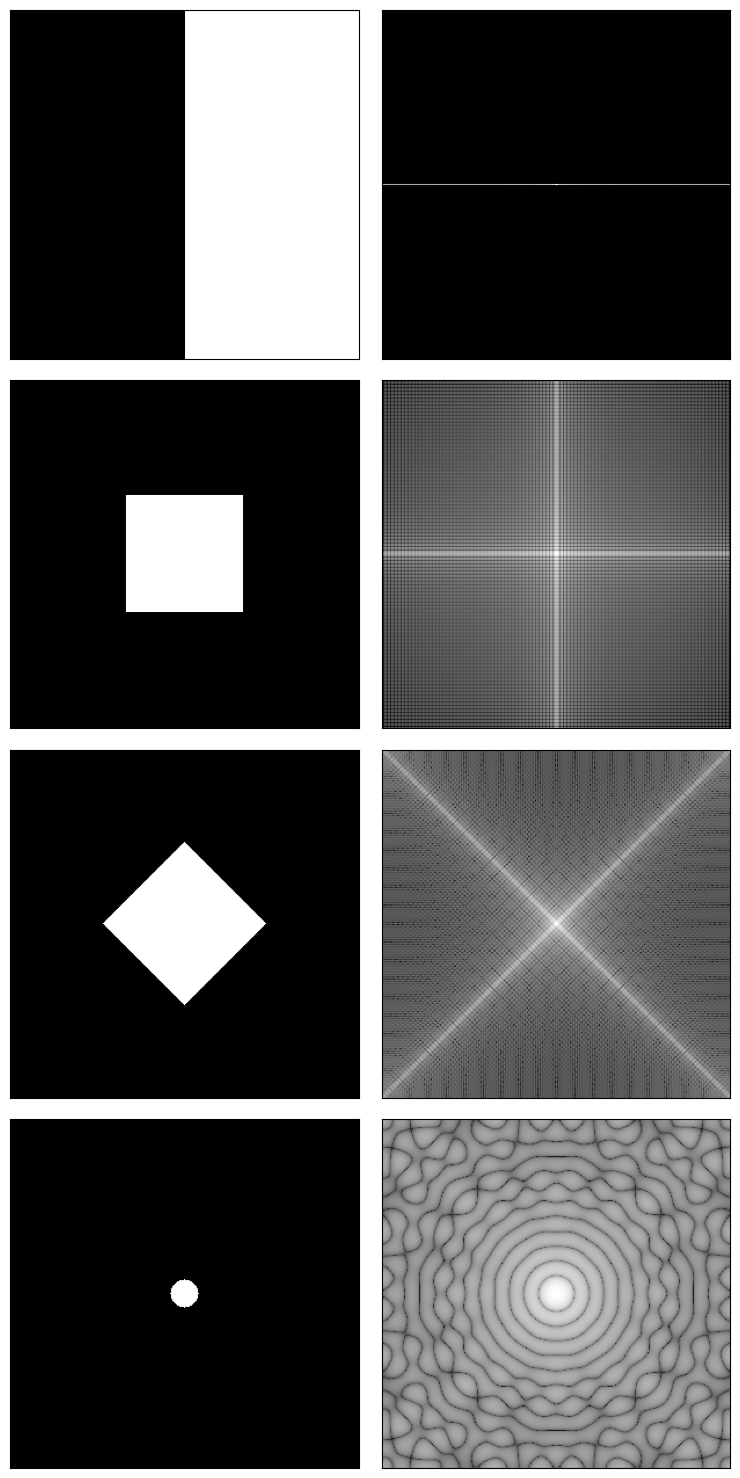

In [143]:
fig1 = plt.figure(figsize=(8,15), dpi= 100, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = fig1.add_subplot(421), fig1.add_subplot(422),\
    fig1.add_subplot(423), fig1.add_subplot(424), fig1.add_subplot(425), fig1.add_subplot(426), \
    fig1.add_subplot(427), fig1.add_subplot(428),

N=301
X0, Y0 = np.meshgrid(np.arange(N), np.arange(N))
X, Y = X0-int(N/2), Y0-int(N/2)
im1=np.zeros((N, N))
im1[np.where(X>0)]=255
im2 = np.fft.fftshift(np.fft.fft2(im1))
ax1.imshow(im1, cmap='gray')
ax2.imshow(np.log(1.+np.abs(im2)), cmap='gray')

im3 = np.zeros((N,N))
im3[(np.abs(X)<N/6)&(np.abs(Y)<N/6)]=255
im4 = np.fft.fftshift(np.fft.fft2(im3))
ax3.imshow(im3, cmap='gray')
ax4.imshow(np.log(1.+np.abs(im4)), cmap='gray')


Xr = (X)*np.cos(np.pi/4)+(Y)*np.sin(np.pi/4)
Yr = -(X)*np.sin(np.pi/4)+(Y)*np.cos(np.pi/4)
im5 = np.zeros((N,N))
im5[(np.abs(Xr)<N/6)&(np.abs(Yr)<N/6)]=255
im6 = np.fft.fftshift(np.fft.fft2(im5))

ax5.imshow(im5, cmap='gray')
ax6.imshow(np.log(1.+np.abs(im6)), cmap='gray')


im7 = np.zeros((N,N))
im7[np.abs(X**2+Y**2)<(N/25)**2]=255
im8 = np.fft.fftshift(np.fft.fft2(im7))
ax7.imshow(im7, cmap='gray')
ax8.imshow(np.log(1.+np.abs(im8)), cmap='gray')

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


fig1.tight_layout()

plt.show()

## Ideal Low Pass Filtering

2D DFT 행렬을 DC 인자를 중앙에 배치하여 재배열했을 경우, 원본 이미지에서 낮은 픽셀 빈도를 갖는 성분은 중앙 (즉, $(u,v) \approx (0,0)$) 근처 에 모이게 된다. 낮은 빈도를 갖는다는 것은 공간 상에서 신호 주기가 크다는 의미고, 역공간에서는 ‘1/주기’가 작은 값으로 대응이 될 것이므로, $(u, v)$ 가 중앙 부분으로 몰리게 되는 것이다. 따라서, 원본 이미지의 로우-패스 필터링을 하고 싶다면, 푸리에 변환 된 행렬의 중앙 부분만 따로 골라내어 다시 역변환하면 될 것이다.

가장 간단히 생각 할 수 있는 방법은 원점 주위의 특정 반경 안에 들어오는 2D DFT 이미지만 뽑아 역변환 해주는 것이며 이를 ideal low pass filtering 이라 한다.

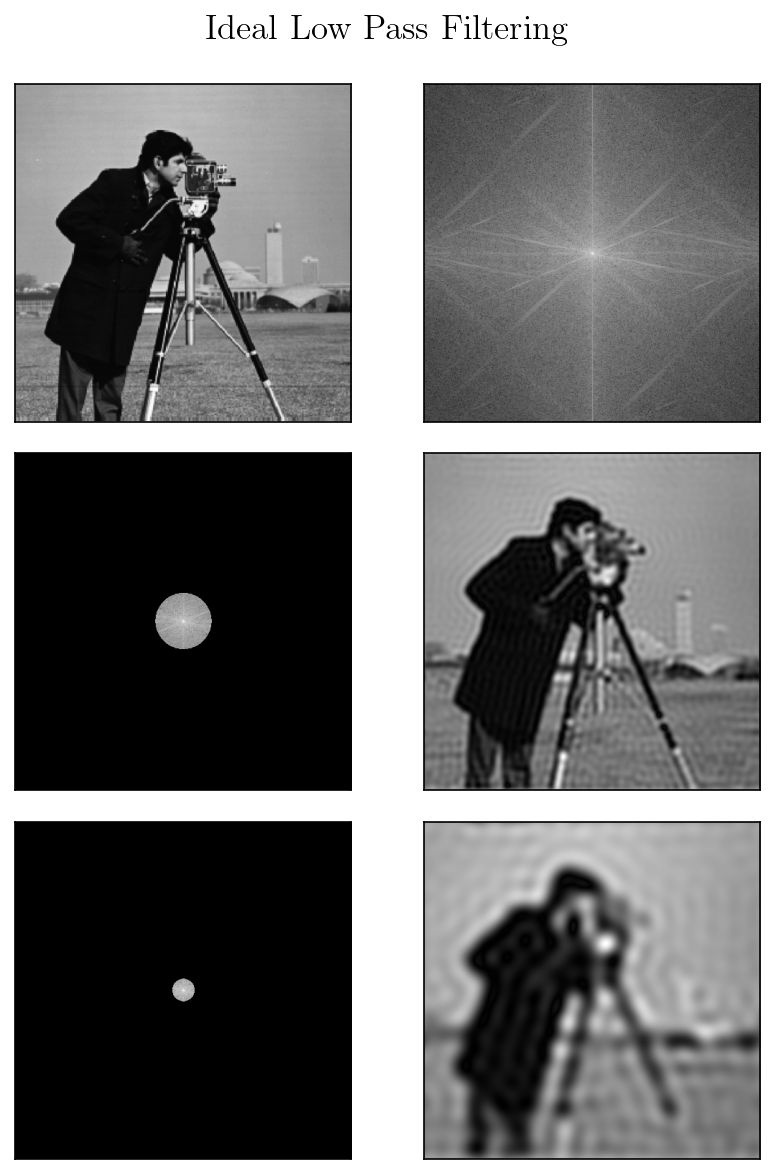

In [145]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

ax1.imshow(img1, cmap='gray')
img2 = np.fft.fftshift(np.fft.fft2(img1))
ax2.imshow(np.log(1+np.abs(img2)), cmap='gray')



X0, Y0 = np.meshgrid(np.arange(img1.shape[1]), np.arange(img1.shape[0]))    
X = X0-X0.mean()
Y = Y0-Y0.mean()
R1=min(img1.shape[0], img1.shape[1])/12.
img3=img2.copy()
img3[np.where(X**2+Y**2>R1**2)]=0

ax3.imshow(np.log(1+np.abs(img3)), cmap='gray')
img4 = np.fft.ifft2(img3)
ax4.imshow(np.abs(img4), cmap='gray')

R2=min(img1.shape[0], img1.shape[1])/30.
img5=img2.copy()
img5[np.where(X**2+Y**2>R2**2)]=0

ax5.imshow(np.log(1+np.abs(img5)), cmap='gray')
img6 = np.fft.ifft2(img5)
ax6.imshow(np.abs(img6), cmap='gray')

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


fig1.suptitle("Ideal Low Pass Filtering")
fig1.tight_layout()
plt.show()

## Ideal High Pass Filtering

Ideal low pass filtering 과 반대로 생각해 주면 된다. 

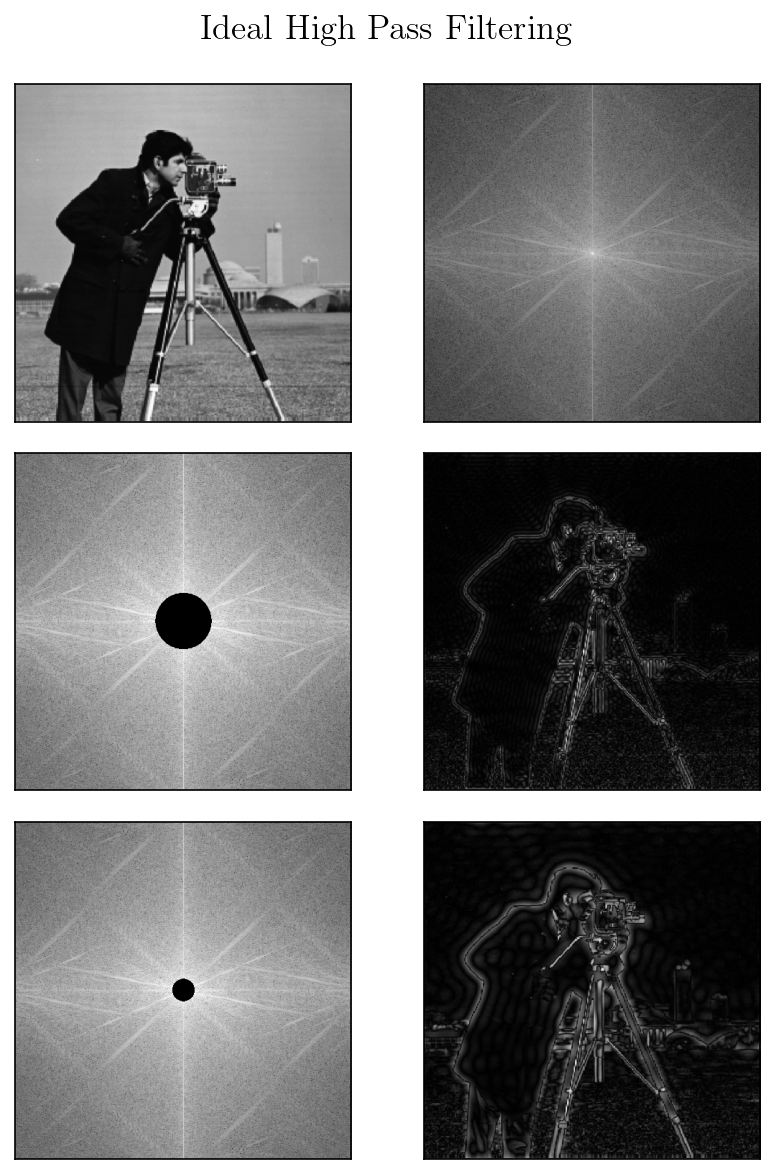

In [146]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

ax1.imshow(img1, cmap='gray')
img2 = np.fft.fftshift(np.fft.fft2(img1))
ax2.imshow(np.log(1+np.abs(img2)), cmap='gray')



X0, Y0 = np.meshgrid(np.arange(img1.shape[1]), np.arange(img1.shape[0]))    
X = X0-X0.mean()
Y = Y0-Y0.mean()
R1=min(img1.shape[0], img1.shape[1])/12.
img3=img2.copy()
img3[np.where(X**2+Y**2<R1**2)]=0

ax3.imshow(np.log(1+np.abs(img3)), cmap='gray')
img4 = np.fft.ifft2(img3)
ax4.imshow(np.abs(img4), cmap='gray')

R2=min(img1.shape[0], img1.shape[1])/30.
img5=img2.copy()
img5[np.where(X**2+Y**2<R2**2)]=0

ax5.imshow(np.log(1+np.abs(img5)), cmap='gray')
img6 = np.fft.ifft2(img5)
ax6.imshow(np.abs(img6), cmap='gray')

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig1.suptitle("Ideal High Pass Filtering")
fig1.tight_layout()
plt.show()

## 버터워스 필터링 (Butterworth filtering)

Ideal low/high pass filter 는 계단 함수 형태로, 그 과정에서 물결무늬 같은 원하지 않는 패턴이 생성된 것도 확인할 수 있었다. 이러한 부작용을 방지하기 위해 컷오프 거리를 기준으로 로우-패스 혹은 하이-패스 영역을 설정하는 방식을 계단 함수가 아닌, 조금 더 부드러운 연속 함수로 바꿀 수 있다. 그중 하나가 버터위스 필터링으로 다음과 같이 정의된다.

$$
\begin{aligned}
\text{Low pass filter } h(u,\,v) &= \dfrac{1}{1+\left( 1+\dfrac{(u^2+d^2)^{1/2}}{D} \right)^{2n}} \\
\text{High pass filter } h(u,\,v) &= \dfrac{1}{1+\left(1+\dfrac{D}{(u^2+d^2)^{1/2}}\right)^{2n}} 
\end{aligned}
$$


In [149]:
def butterworth2d(img, kind, D, n):
    """
    Realization of Butterworth filtering in 2D
    
    parameters
    ----------
    img : 2D grayscale image
    kind : 0 = highpass, 1 = lowpass
    D : diameter
    n : order
    """
    
    
    X0, Y0 = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))    
    X = X0-X0.mean()
    Y = Y0-Y0.mean()
    R = np.sqrt(X**2+Y**2)
    if kind==0:
        return 1.0/(1.+(D/R)**(2*n))
    elif kind == 1:
        return 1.0/(1.+(R/D)**(2*n))
    else :
        return None
    


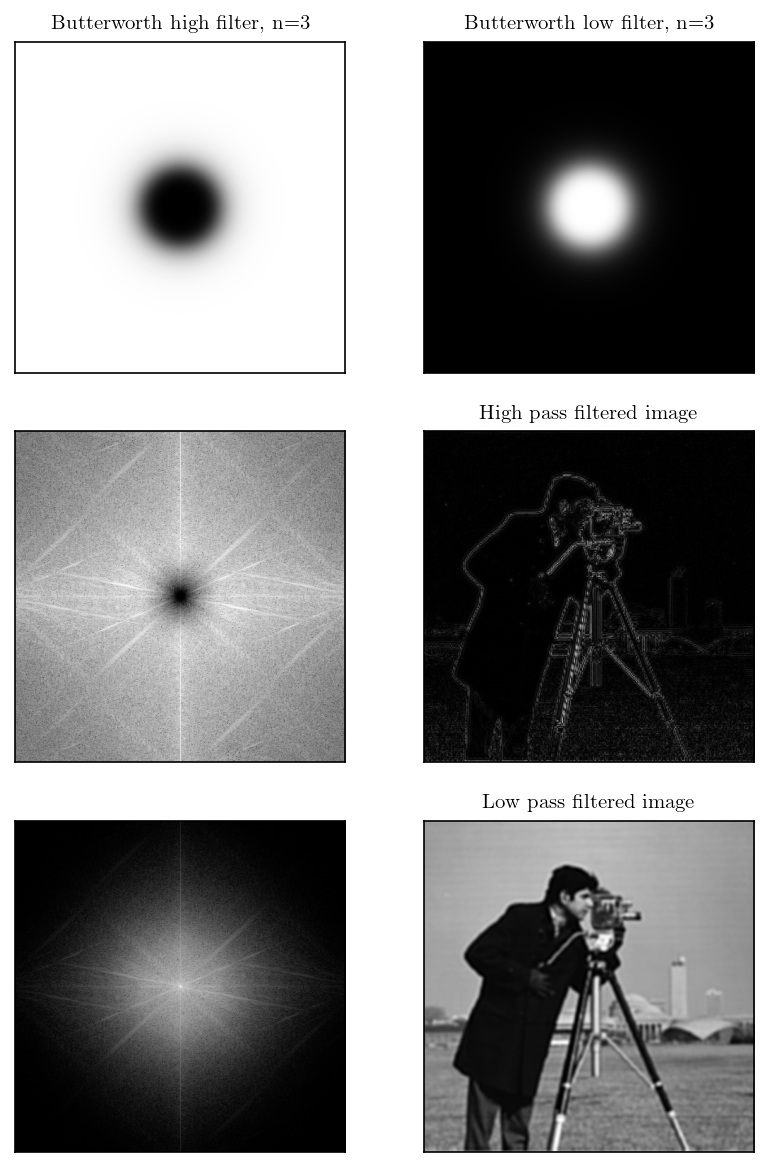

In [150]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

img_bth = butterworth2d(np.ones((img1.shape[0], img1.shape[1])), 0, 60, 3)
ax1.imshow(img_bth, cmap='gray')
ax1.set_title("Butterworth high filter, n=3", size=10)
img_btl = butterworth2d(np.ones((img1.shape[0], img1.shape[1])), 1, 60, 3)
ax2.imshow(img_btl, cmap='gray')
ax2.set_title("Butterworth low filter, n=3", size=10)

img_fft = np.fft.fftshift(np.fft.fft2(img1))



img3 = img_fft*img_bth

ax3.imshow(np.log(1+np.abs(img3)), cmap='gray')
img4 = np.fft.ifft2(img3)
ax4.imshow(np.abs(img4), cmap='gray')
ax4.set_title("High pass filtered image", size=10)

img5=mg3 = img_fft*img_btl

ax5.imshow(np.log(1+np.abs(img5)), cmap='gray')
img6 = np.fft.ifft2(img5)
ax6.imshow(np.abs(img6), cmap='gray')
ax6.set_title("Low pass filtered image", size=10)
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig1.tight_layout()

plt.show()

## Gaussian Filtering

In [367]:
def gaussian_filter_2d(img, kind, sigma):
    """
    Realization of Butterworth filtering in 2D
    
    parameters
    ----------
    img : 2D grayscale image
    kind : 0 = highpass, 1 = lowpass
    sigma : std of Gaussian distribution
    """
    
    
    X0, Y0 = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))    
    X = X0-X0.mean()
    Y = Y0-Y0.mean()
    R = np.sqrt(X**2+Y**2)
    if kind==0:
        return 1.-np.exp(-R**2/(2*sigma**2))
    elif kind == 1:
        return np.exp(-R**2/(2*sigma**2))
    else :
        return None
    



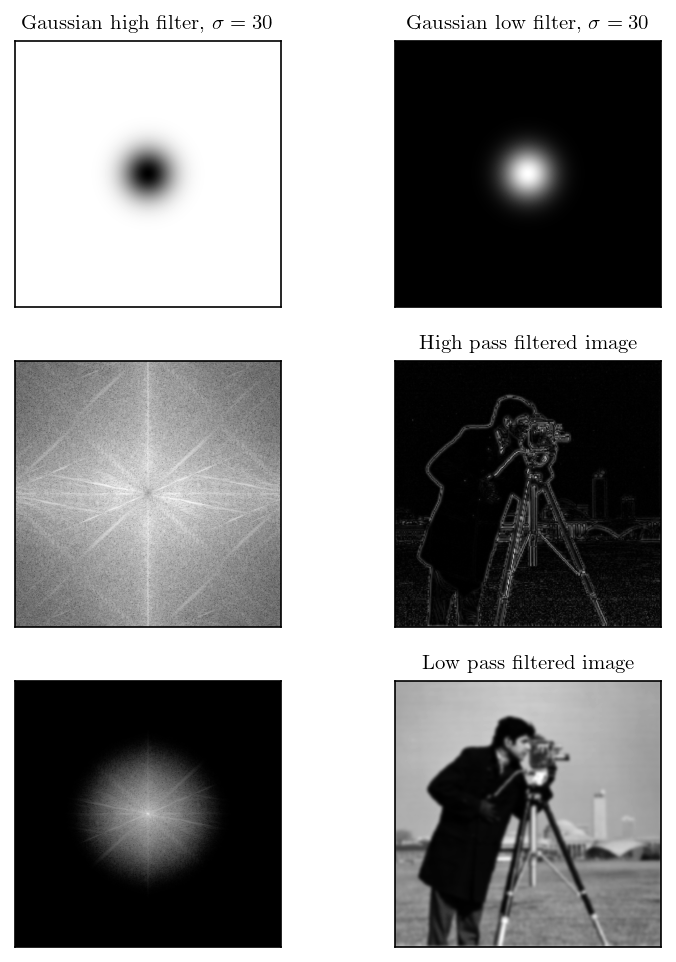

In [372]:
img1=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

img_gh = gaussian_filter_2d(np.ones((img1.shape[0], img1.shape[1])), 0, 30)
ax1.imshow(img_gh, cmap='gray')
ax1.set_title("Gaussian high filter, $\\sigma=30$", size=10)
img_gl = gaussian_filter_2d(np.ones((img1.shape[0], img1.shape[1])), 1, 30)
ax2.imshow(img_gl, cmap='gray')
ax2.set_title("Gaussian low filter, $\\sigma=30$", size=10)

img_fft = np.fft.fftshift(np.fft.fft2(img1))

img3 = img_fft*img_gh

ax3.imshow(np.log(1+np.abs(img3)), cmap='gray')
img4 = np.fft.ifft2(img3)
ax4.imshow(np.abs(img4), cmap='gray')
ax4.set_title("High pass filtered image", size=10)

img5=mg3 = img_fft*img_gl

ax5.imshow(np.log(1+np.abs(img5)), cmap='gray')
img6 = np.fft.ifft2(img5)
ax6.imshow(np.abs(img6), cmap='gray')
ax6.set_title("Low pass filtered image", size=10)
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

## 위상 보존 필터 (zero-phase-shift filter), 위상 비보존 필터 (Nonzero-phase-shift filter)

우리는 지금까지 원본 이미지 $f(x,\,y)$의 역공간 $F(u,\,v)$ 에서 작업해 왔다. $F(u,\,v)$ 는 복소함수로 실수부 $R(u,\,v)$ 와 허수부 $I(u,\,v)$ 가 존재하여 $F(u,\,v) = R(u,\,v) +iI(u,\,v)$ 이다. 이 때 $\arctan \left( \dfrac{I(u,\,v)}{R(u,\,v)}\right)$ 를 $F(u,\,v)$ 의 위상이라고 한다. 

만약 어떤 필터에 의해 위상이 변하지 않는다면 이를 **위상 보존 필터**라 하고, 그렇지 않다면 **위상 비보존 필터** 라 한다.

## 밴드삭제 필터링, 놋치 필터링.

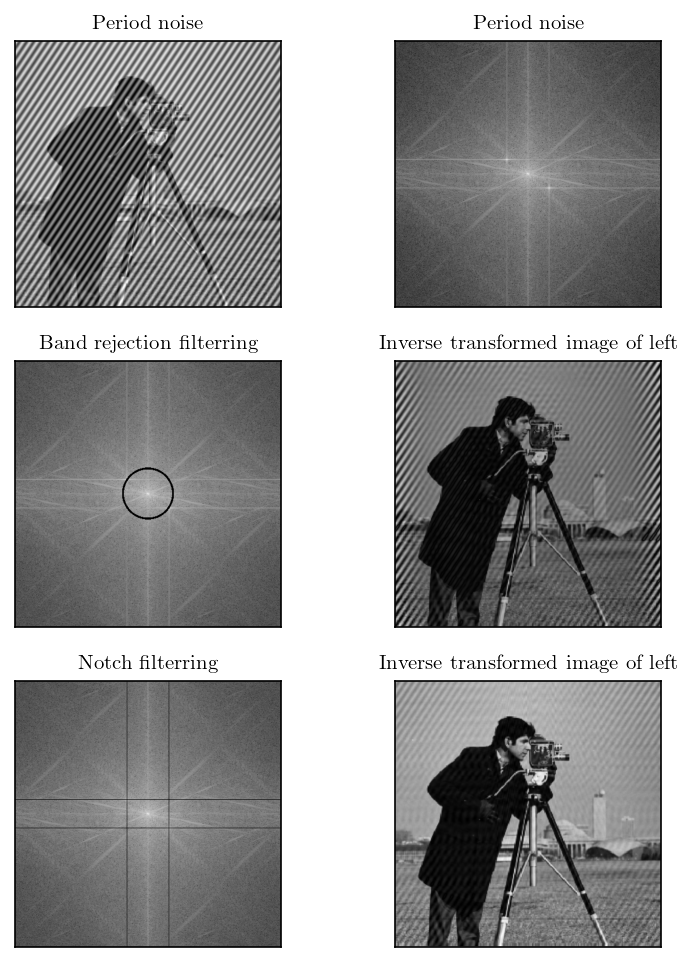

In [550]:
img0=cv2.cvtColor(cv2.imread("./img_filter_01.jpg"), cv2.COLOR_BGR2GRAY)[::2,::2]
fig1 = plt.figure(figsize=(6,8), dpi= 150, facecolor='w', edgecolor='k')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)
# periodic noise
X, Y = np.meshgrid(np.arange(img0.shape[1]), np.arange(img0.shape[0]))
img_pn=img1.astype(np.int64)+150*np.sin(X/2+Y/3)
ax1.imshow(img_pn, cmap='gray')
ax1.set_title("Period noise", size=10)

img_fft = np.fft.fftshift(np.fft.fft2(img_pn))
ax2.imshow(np.log(1.0+np.abs(img_fft)), cmap='gray')
ax2.set_title("Period noise", size=10)


X, Y = np.meshgrid(np.arange(img0.shape[1]), np.arange(img0.shape[0]))
X0, Y0 = X.mean(), Y.mean()
R=np.sqrt(X**2+Y**2)
img_fft_bf = np.array(img_fft, copy=True)
img_fft_bf[(((X-X0)**2+(Y-Y0)**2)<2100)& (((X-X0)**2+(Y-Y0)**2)>1800)]=0.+0.j
ax3.imshow(np.log(1.0+np.abs(img_fft_bf)), cmap='gray')
ax3.set_title("Band rejection filterring", size=10)
ax4.imshow(np.abs(np.fft.ifft2(img_fft_bf)), cmap='gray')
ax4.set_title("Inverse transformed image of left", size=10)

img_fft_nf = np.array(img_fft, copy=True)
img_fft_nf[X==197]=0
img_fft_nf[X==271]=0
img_fft_nf[Y==210]=0
img_fft_nf[Y==260]=0
ax5.imshow(np.log(1.0+np.abs(img_fft_nf)), cmap='gray')
ax5.set_title("Notch filterring", size=10)
ax6.imshow(np.abs(np.fft.ifft2(img_fft_nf)), cmap='gray')
ax6.set_title("Inverse transformed image of left", size=10)

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Periodic noise reduction - Bragg filtering

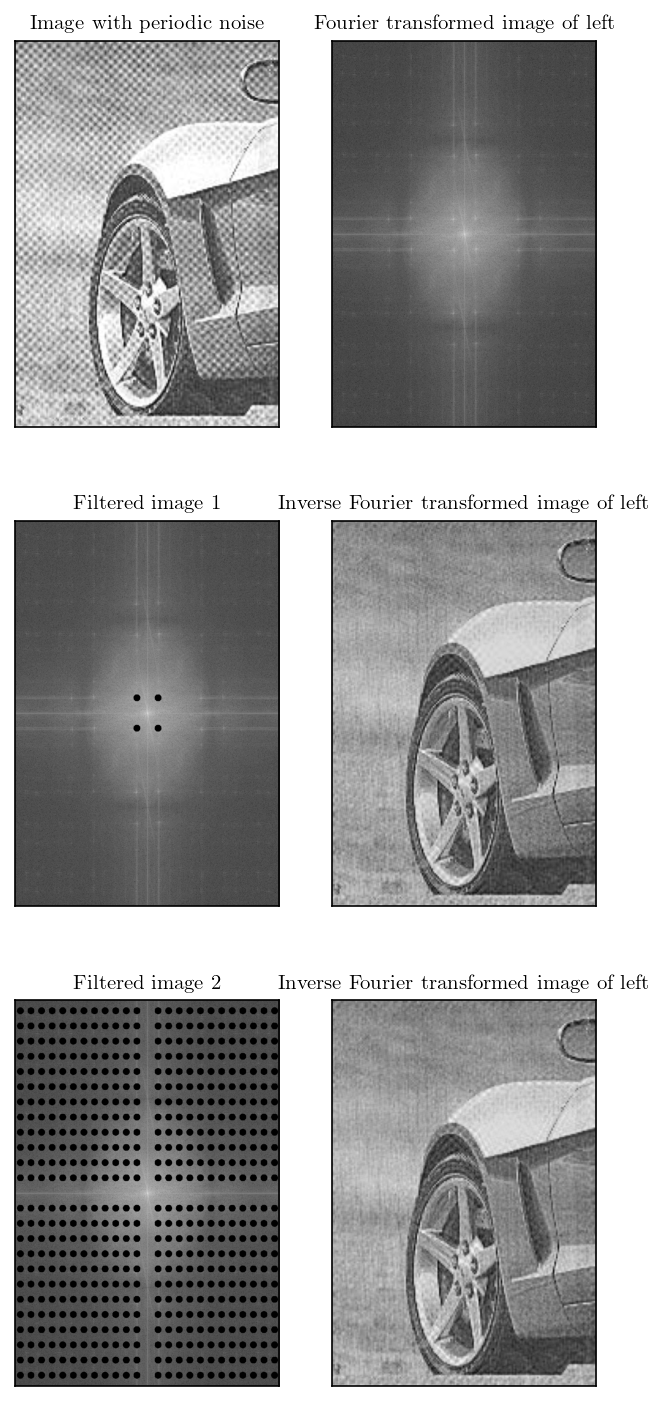

In [682]:
img0=cv2.cvtColor(cv2.imread("./img_dft_01.jpg"), cv2.COLOR_BGR2GRAY)
fig1 = plt.figure(figsize=(5,12), dpi= 150, facecolor='w', edgecolor='w')
ax1, ax2, ax3, ax4, ax5, ax6 = fig1.add_subplot(321), fig1.add_subplot(322), fig1.add_subplot(323),\
                        fig1.add_subplot(324), fig1.add_subplot(325), fig1.add_subplot(326)

X, Y = np.meshgrid(np.arange(img0.shape[1]), np.arange(img0.shape[0]))
X0, Y0 = X.mean(), Y.mean()
X, Y= X-X0, Y-Y0

R=np.sqrt(X**2+Y**2)

ax1.imshow(img0, cmap='gray')
ax1.set_title("Image with periodic noise", size=10)

img_fft = np.fft.fftshift(np.fft.fft2(img0))
ax2.imshow(np.log(1.0+np.abs(img_fft)), cmap='gray')
ax2.set_title("Fourier transformed image of left", size=10)





R0=9
X1, X2 = X0-316, -(X0-316)
Y1, Y2 = Y0-462, -(Y0-462)

img_c1=np.array(img_fft, copy=True)
Nl=1
ll = list(range(-Nl, Nl+1))
ll.remove(0)

for dd in ll:
    for ss in ll:
        img_c1[((X-dd*X1)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j
        img_c1[((X-dd*X2)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j
ax3.imshow(np.log(1.0+np.abs(img_c1)), cmap='gray')
ax3.set_title("Filtered image 1", size=10)

ax4.imshow(np.abs(np.fft.ifft2(img_c1)), cmap='gray')
ax4.set_title("Inverse Fourier transformed image of left", size=10)


img_c2=np.array(img_fft, copy=True)
Nl=12
ll = list(range(-Nl, Nl+1))
ll.remove(0)
for dd in ll:
    for ss in ll:
        img_c2[((X-dd*X1)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j
        img_c2[((X-dd*X2)**2+(Y-ss*Y1)**2) <= R0**2]=0+0j

ax5.imshow(np.log(1.0+np.abs(img_c2)), cmap='gray')
ax5.set_title("Filtered image 2", size=10)

ax6.imshow(np.abs(np.fft.ifft2(img_c2)), cmap='gray')
ax6.set_title("Inverse Fourier transformed image of left", size=10)

img_c2=np.array(img_fft, copy=True)
for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Deblurring using inverse filtering


잘 안됨... 더 알아 봐야 할 듯..

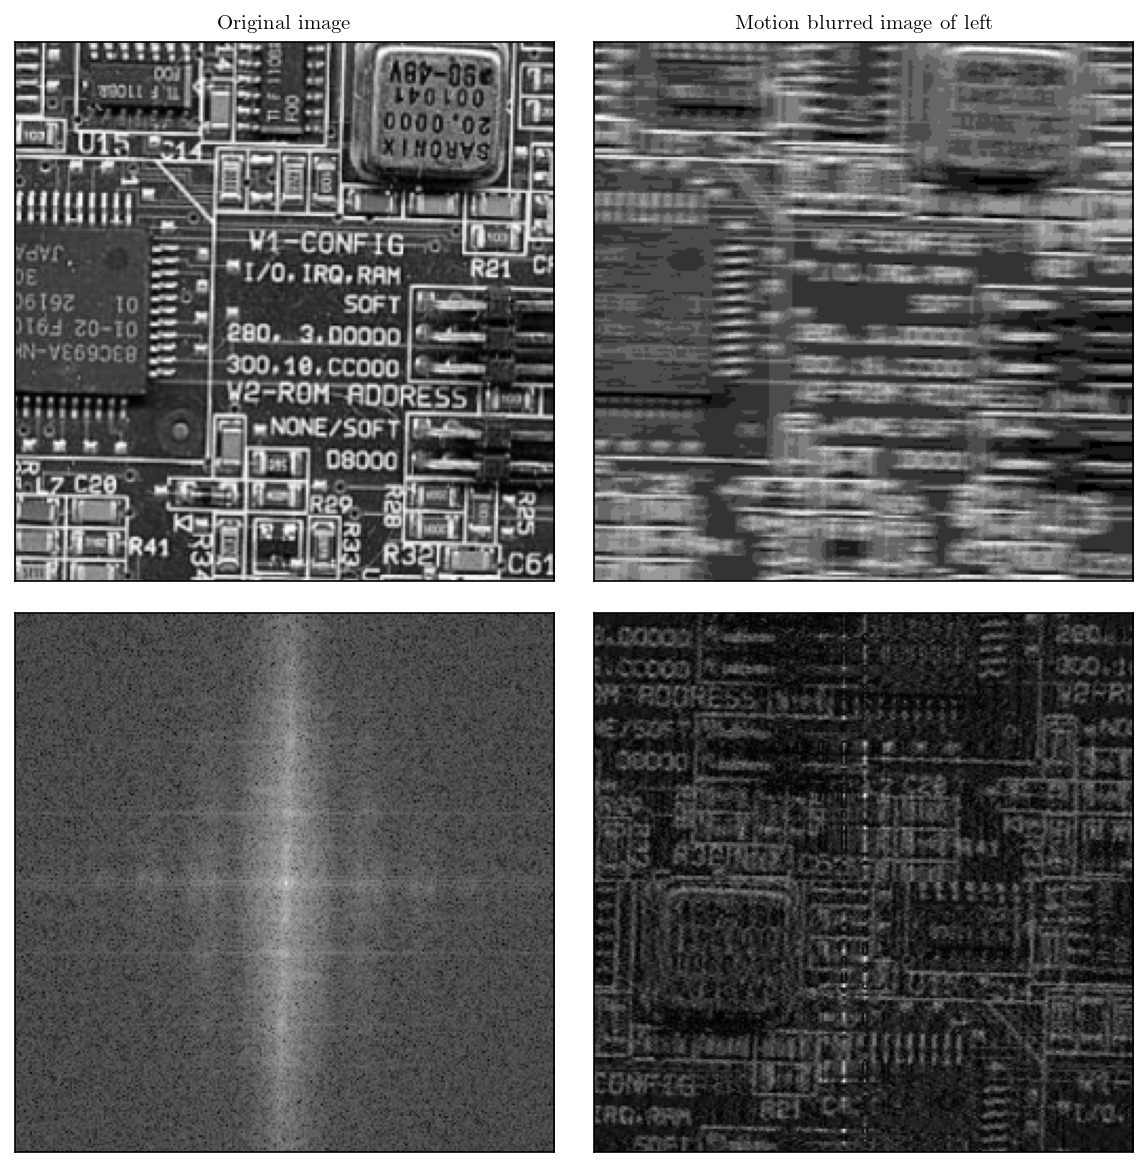

In [217]:
## to be done ..

img01 = cv2.cvtColor(cv2.imread("./img_deblur_01.jpg"), cv2.COLOR_BGR2GRAY)
fig1 = plt.figure(figsize=(8,8), dpi= 150, facecolor='w', edgecolor='w')
ax1, ax2, ax3, ax4= fig1.add_subplot(221), fig1.add_subplot(222), fig1.add_subplot(223),\
                        fig1.add_subplot(224)
img0 = cv2.resize(img01, (256, 256))
X, Y = np.meshgrid(np.arange(img0.shape[1]), np.arange(img0.shape[0]))
X0, Y0 = X.mean(), Y.mean()
X, Y= X-X0, Y-Y0

R=np.sqrt(X**2+Y**2)

ax1.imshow(img0, cmap='gray')
ax1.set_title("Original image", size=10)


size = 256
nblur = 10
cs = int((size)/2)
motion_blur = np.zeros((size, size))
motion_blur[cs, cs:cs+nblur] = np.ones((nblur,))
motion_blur = motion_blur / size


dst = cv2.filter2D(img0, -1, motion_blur)

# img_fft = np.fft.fftshift(np.fft.fft2(img0))
ax2.imshow(dst, cmap='gray')
ax2.set_title("Motion blurred image of left", size=10)


fft_blur = np.fft.fftshift(np.fft.fft2(motion_blur.astype(np.float64)))*10

thr = 0.1
abb = np.abs(fft_blur)
th = abb.min()+(abb.max()-abb.min())*thr

Hinv = np.zeros(fft_blur.shape, dtype=np.complex64)
Hinv[abb>th]=1.0/fft_blur[abb>th]

imgfft = np.fft.fftshift(np.fft.fft2(dst))

ax3.imshow(np.log(1.0+np.abs(imgfft)), cmap='gray')
#ax3.plot((315,315), (0,315), "r-")

#imgfft[:, 314:317]=0

ax4.imshow(np.abs(np.fft.ifft2(imgfft*Hinv)), cmap='gray')

for ax in fig1.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig1.tight_layout()
plt.show()